In [334]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.interpolate import CubicSpline 
from datetime import timedelta
import seaborn as sns; sns.set(style="ticks", color_codes=True)
import missingno as ms
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor

# Exploratory Data Analysis

There are two files we use in this analysis: one containing service calls data and another one containing incident logs.

In [5]:
df_service = pd.read_csv('./input/police-department-calls-for-service.csv')

In [7]:
df_incidents = pd.read_csv('./input/police-department-incidents.csv')

## Service Calls

Before applying any transformation/manipulation, let's look at the original data.

In [21]:
df_service.head()

,Crime Id,Original Crime Type Name,Report Date,Call Date,Offense Date,Call Time,Call Date Time,Disposition,Address,City,State,Agency Id,Address Type,Common Location
0,193274171,Passing Call,2019-11-23T00:00:00.000,2019-11-23T00:00:00.000,2019-11-23T00:00:00.000,23:54,2019-11-23T23:54:00.000,HAN,1000 Block Of Larkin St,San Francisco,CA,1,Premise Address,NaN
1,193274162,Fight No Weapon,2019-11-23T00:00:00.000,2019-11-23T00:00:00.000,2019-11-23T00:00:00.000,23:45,2019-11-23T23:45:00.000,CAN,100 Block Of Ocean Av,San Francisco,CA,1,Premise Address,NaN
2,193274160,Passing Call,2019-11-23T00:00:00.000,2019-11-23T00:00:00.000,2019-11-23T00:00:00.000,23:51,2019-11-23T23:51:00.000,HAN,400 Block Of Duboce Av,San Francisco,CA,1,Premise Address,NaN
3,193274158,Well Being Check,2019-11-23T00:00:00.000,2019-11-23T00:00:00.000,2019-11-23T00:00:00.000,23:50,2019-11-23T23:50:00.000,HAN,King St/4th St,San Francisco,CA,1,Intersection,NaN
4,193274157,Passing Call,2019-11-23T00:00:00.000,2019-11-23T00:00:00.000,2019-11-23T00:00:00.000,23:50,2019-11-23T23:50:00.000,HAN,100 Block Of Scott St,San Francisco,CA,1,Common Location,"Duboce Park, Sf"


Applying datetime transformation to some tags..

In [53]:
# Convert some data into timestamp
timestamp_cols = ['Report Date', 'Call Date', 'Offense Date', 'Call Date Time']

for t in timestamp_cols:
    df_service[t] = pd.to_datetime(df_service[t])

Checking data types..

In [15]:
df_service.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3035330 entries, 0 to 3035329
Data columns (total 14 columns):
 #   Column                    Dtype 
---  ------                    ----- 
 0   Crime Id                  int64 
 1   Original Crime Type Name  object
 2   Report Date               object
 3   Call Date                 object
 4   Offense Date              object
 5   Call Time                 object
 6   Call Date Time            object
 7   Disposition               object
 8   Address                   object
 9   City                      object
 10  State                     object
 11  Agency Id                 int64 
 12  Address Type              object
 13  Common Location           object
dtypes: int64(2), object(12)
memory usage: 324.2+ MB


Checking if there are anomalous data..

In [135]:
df_service.describe()

,Crime Id,Agency Id,day_of_week,call_hour,call_day_of_week,call_month,call_day_of_month
count,3.035330e+06,3035330.0,3.035330e+06,3.035330e+06,3.035330e+06,3.035330e+06,3.035330e+06
mean,1.774466e+08,1.0,2.965945e+00,1.324169e+01,2.965945e+00,6.693759e+00,1.564641e+01
std,1.063593e+07,0.0,1.976567e+00,6.047816e+00,1.976567e+00,3.254363e+00,8.797109e+00
min,1.609033e+08,1.0,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
25%,1.705836e+08,1.0,1.000000e+00,9.000000e+00,1.000000e+00,4.000000e+00,8.000000e+00
50%,1.802026e+08,1.0,3.000000e+00,1.400000e+01,3.000000e+00,7.000000e+00,1.600000e+01
75%,1.836520e+08,1.0,5.000000e+00,1.800000e+01,5.000000e+00,9.000000e+00,2.300000e+01
max,1.932742e+08,1.0,6.000000e+00,2.300000e+01,6.000000e+00,1.200000e+01,3.100000e+01


A quick look at the distribution of each numeric variables..

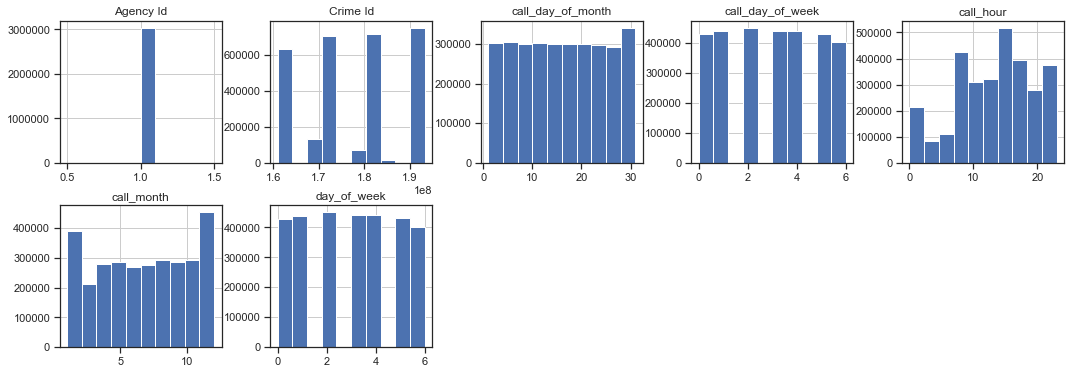

In [187]:
df_service.hist(figsize=(18, 6), layout=(2, 5));

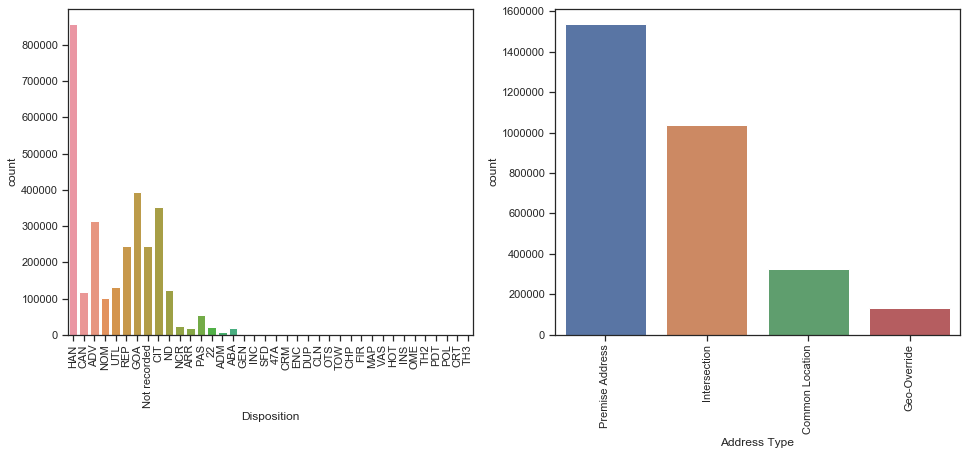

In [200]:
categorical = ['Disposition',  'Address Type']
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
for variable, subplot in zip(categorical, ax.flatten()):
    sns.countplot(df_service[variable], ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(90)

Checking NULL values..

In [189]:
df_service.isnull().sum(axis = 0)

Crime Id                          0
Original Crime Type Name          0
Report Date                       0
Call Date                         0
Offense Date                      0
Call Time                         0
Call Date Time                    0
Disposition                       0
Address                           0
City                          75502
State                             0
Agency Id                         0
Address Type                      0
Common Location             2708815
day_of_week                       0
call_hour                         0
call_day_of_week                  0
call_month                        0
call_day_of_month                 0
dtype: int64

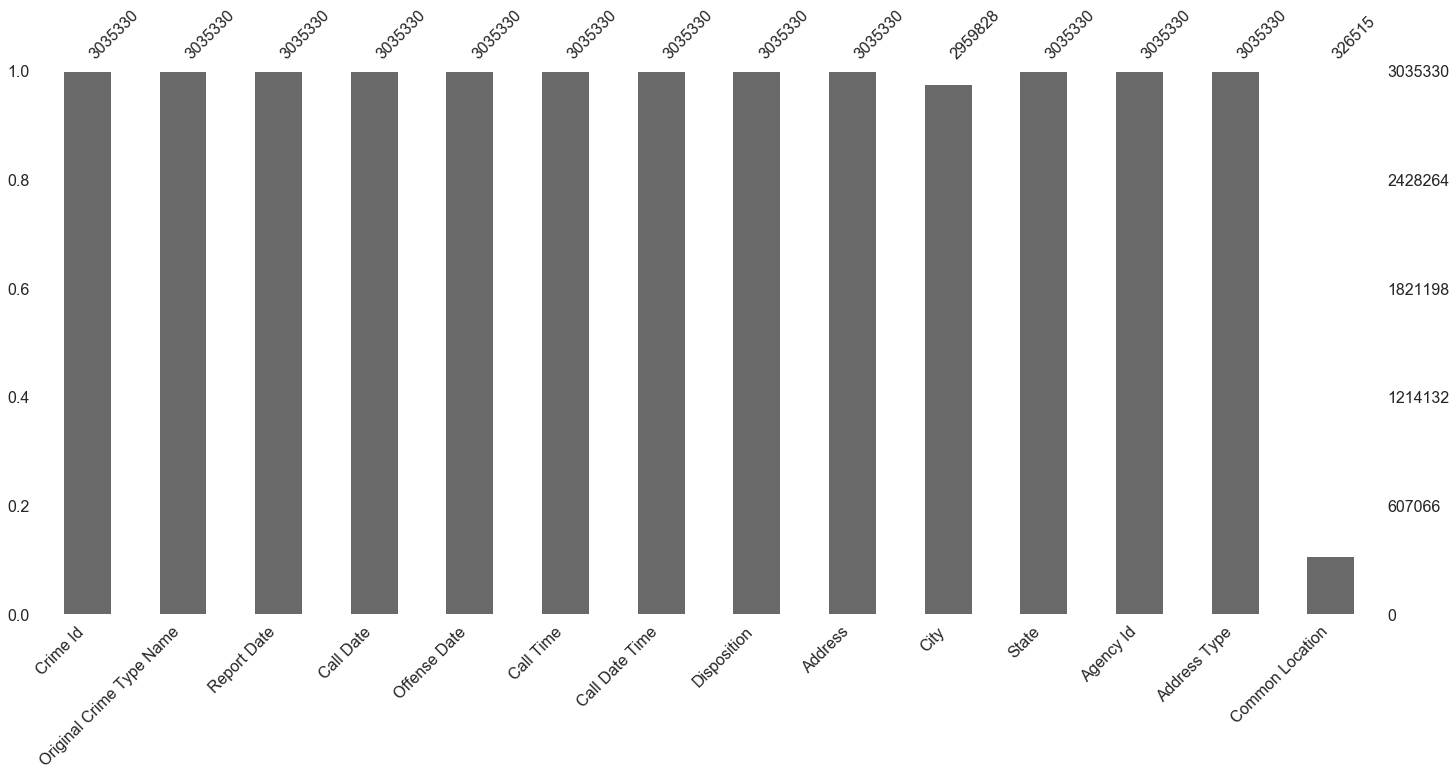

In [31]:
ms.bar(df_service)

'Common location' has a lot of NULLS. 'City' has a small fraction of NULLS. We don't use these two tags in the analysis. The rest is fine.

In [50]:
df_service['call_day_of_week'] = pd.to_datetime(df_service['Call Date']).dt.weekday
df_service['call_day_of_month'] = pd.to_datetime(df_service['Call Date']).dt.day
df_service['call_hour'] = pd.to_datetime(df_service['Call Time']).dt.hour
df_service['call_month'] = pd.to_datetime(df_service['Call Date']).dt.month

## Incidents

Taking a peek at the original format..

In [35]:
df_incidents.head()

,IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,Location,PdId
0,180362289,VEHICLE THEFT,STOLEN MOTORCYCLE,Tuesday,2018-05-15T00:00:00.000,10:30,SOUTHERN,NONE,700 Block of TEHAMA ST,-122.411912,37.775207,"{'type': 'Point', 'coordinates': [-122.4119120...",18036228907023
1,180360948,NON-CRIMINAL,"AIDED CASE, MENTAL DISTURBED",Tuesday,2018-05-15T00:00:00.000,04:14,SOUTHERN,NONE,MARKET ST / SOUTH VAN NESS AV,-122.419258,37.775146,"{'type': 'Point', 'coordinates': [-122.4192578...",18036094864020
2,180360879,OTHER OFFENSES,PAROLE VIOLATION,Tuesday,2018-05-15T00:00:00.000,02:01,MISSION,"ARREST, BOOKED",CAPP ST / 21ST ST,-122.417813,37.757101,"{'type': 'Point', 'coordinates': [-122.4178125...",18036087926150
3,180360879,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Tuesday,2018-05-15T00:00:00.000,02:01,MISSION,"ARREST, BOOKED",CAPP ST / 21ST ST,-122.417813,37.757101,"{'type': 'Point', 'coordinates': [-122.4178125...",18036087965010
4,180360879,OTHER OFFENSES,TRAFFIC VIOLATION,Tuesday,2018-05-15T00:00:00.000,02:01,MISSION,"ARREST, BOOKED",CAPP ST / 21ST ST,-122.417813,37.757101,"{'type': 'Point', 'coordinates': [-122.4178125...",18036087965015


Converting string to datetime..

In [207]:
df_incidents['Date'] = pd.to_datetime(df_incidents['Date'])

Checking object type and some stats, similar to what we did on service data

In [32]:
df_incidents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2215024 entries, 0 to 2215023
Data columns (total 13 columns):
 #   Column      Dtype  
---  ------      -----  
 0   IncidntNum  int64  
 1   Category    object 
 2   Descript    object 
 3   DayOfWeek   object 
 4   Date        object 
 5   Time        object 
 6   PdDistrict  object 
 7   Resolution  object 
 8   Address     object 
 9   X           float64
 10  Y           float64
 11  Location    object 
 12  PdId        int64  
dtypes: float64(2), int64(2), object(9)
memory usage: 219.7+ MB


In [136]:
df_incidents.describe()

,IncidntNum,X,Y,PdId,hour
count,2.215024e+06,2.215024e+06,2.215024e+06,2.215024e+06,2.215024e+06
mean,1.040728e+08,-1.224229e+02,3.777076e+01,1.040728e+13,1.341592e+01
std,4.612827e+07,2.983459e-02,4.203596e-01,4.612827e+12,6.534616e+00
min,3.979000e+03,-1.225136e+02,3.770788e+01,3.979630e+08,0.000000e+00
25%,6.124170e+07,-1.224332e+02,3.775302e+01,6.124170e+12,9.000000e+00
50%,1.011558e+08,-1.224166e+02,3.777542e+01,1.011558e+13,1.400000e+01
75%,1.409256e+08,-1.224069e+02,3.778448e+01,1.409256e+13,1.900000e+01
max,9.915824e+08,-1.205000e+02,9.000000e+01,9.915824e+13,2.300000e+01


In [177]:
df_incidents.isnull().sum(axis = 0)

IncidntNum    0
Category      0
Descript      0
DayOfWeek     0
Date          0
Time          0
PdDistrict    1
Resolution    0
Address       0
X             0
Y             0
Location      0
PdId          0
hour          0
dtype: int64

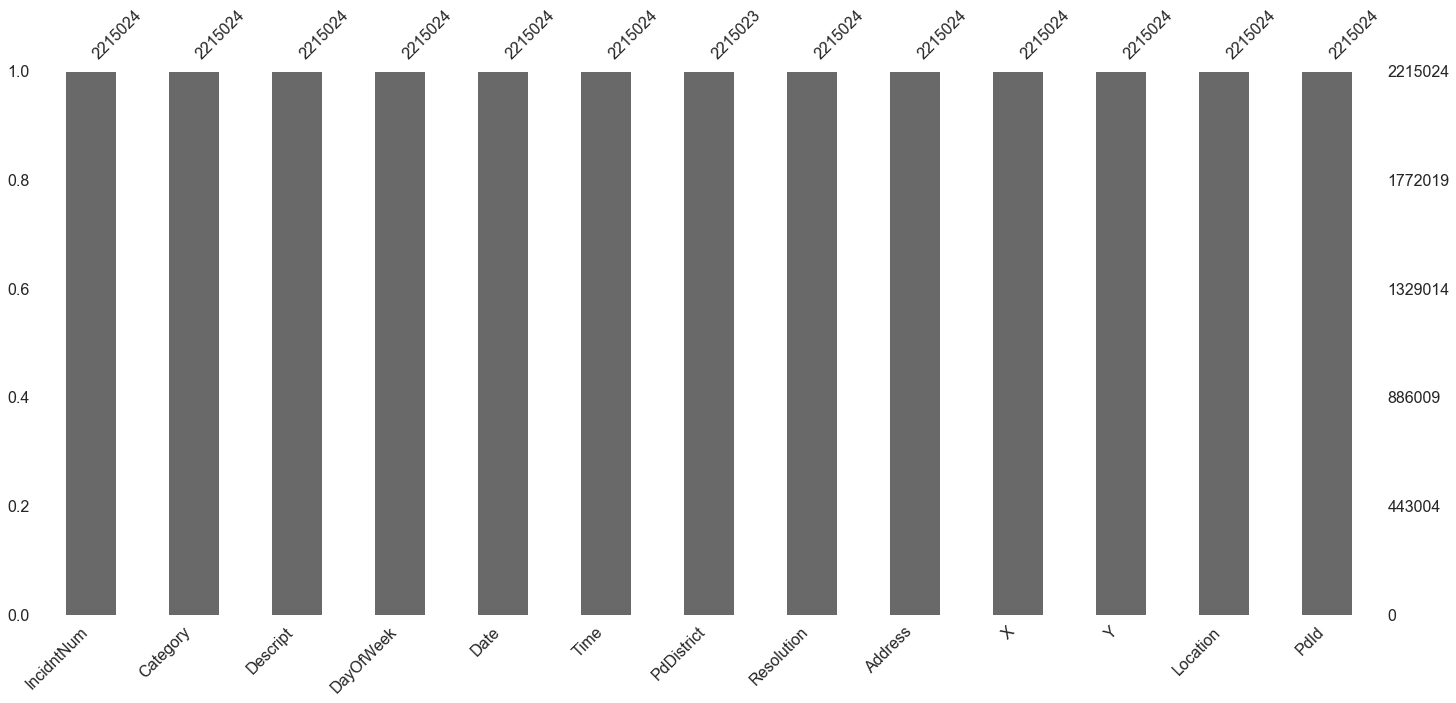

In [33]:
ms.bar(df_incidents)

In [157]:
list(df_incidents)

['IncidntNum',
 'Category',
 'Descript',
 'DayOfWeek',
 'Date',
 'Time',
 'PdDistrict',
 'Resolution',
 'Address',
 'X',
 'Y',
 'Location',
 'PdId',
 'hour']

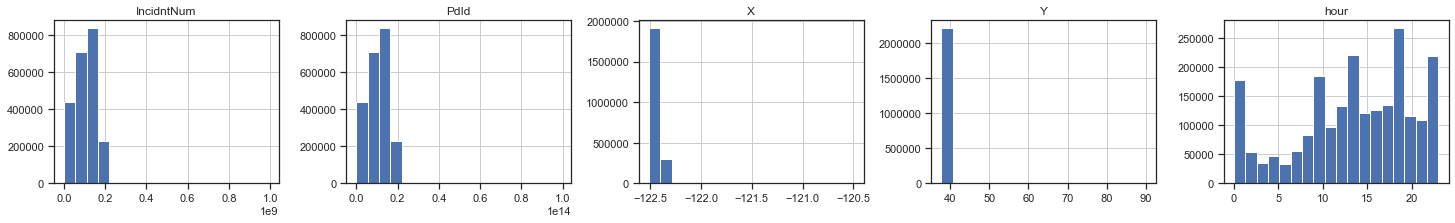

In [175]:
df_incidents.hist(bins=18, figsize=(25, 3), layout=(1, 5));

Looking good in general. Only one missing data on 'PdDistrict'. Now let's visualize some categorical variables.

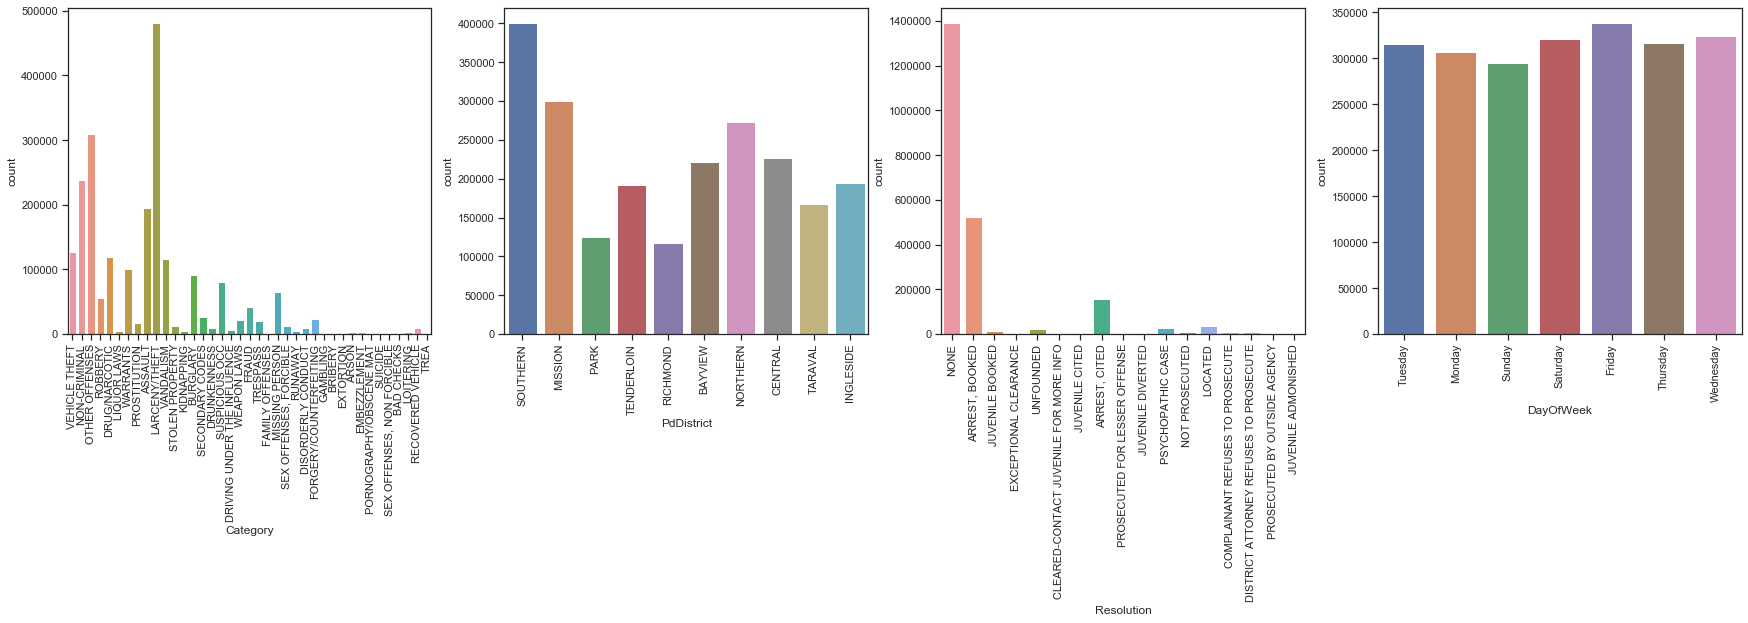

In [174]:
categorical = ['Category', 'PdDistrict', 'Resolution', 'DayOfWeek']
fig, ax = plt.subplots(1, 4, figsize=(30, 6))
for variable, subplot in zip(categorical, ax.flatten()):
    sns.countplot(df_incidents[variable], ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(90)

In [37]:
# Calculate hour and minute of the day
df_incidents['hour'] = pd.to_datetime(df_incidents.Time).dt.hour

/Users/titaristanto/anaconda3/envs/ml/lib/python3.7/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/Users/titaristanto/anaconda3/envs/ml/lib/python3.7/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/Users/titaristanto/anaconda3/envs/ml/lib/python3.7/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/Users/titaristanto/anaconda3/envs/ml/lib/python3.7/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/Users/titaristanto/anaconda3/envs/ml/lib/python3.7/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warning

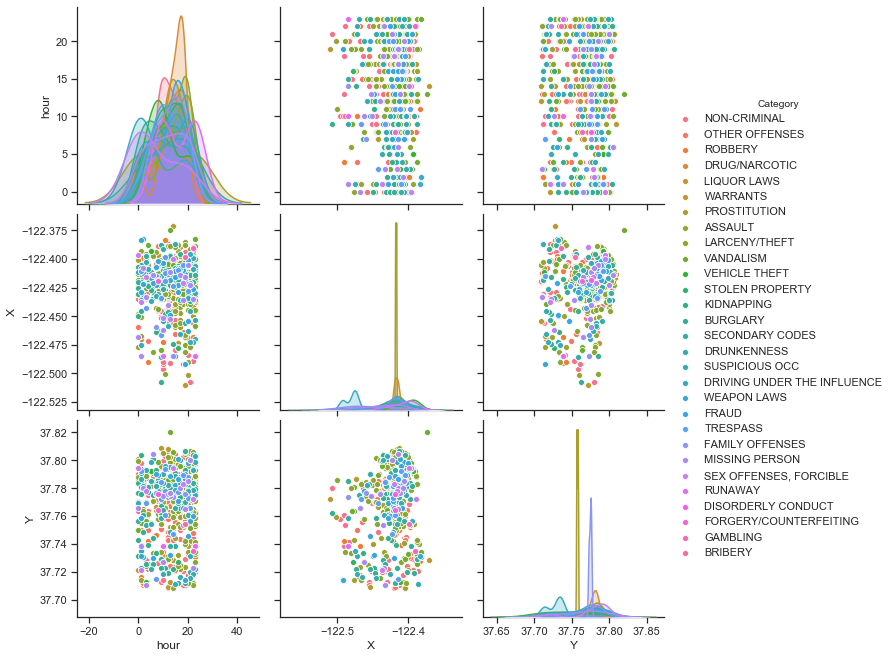

In [40]:
sns.pairplot(df_incidents.loc[1:1000, ['hour', 'X', 'Y', 'Category']], hue='Category', height=3, aspect=1)

## Day of week that had the most average daily calls for service in July 2018 (challenge prompt)

In [211]:
# Get July 2018 data
dfj = df_service[(df_service['Call Date'].dt.month == 7) & (df_service['Call Date'].dt.year == 2018)]

# Resample to daily average
dfj_agg = dfj[['Call Date']].resample('D', on='Call Date').count()
dfj_agg = dfj_agg.rename(columns={'Call Date': 'Daily Count'})
dfj_agg = dfj_agg.reset_index(drop=False)

# Map date to day of the week (str)
dfj_agg['Day of Week'] = pd.to_datetime(dfj_agg['Call Date']).dt.strftime("%A")

# Group by day of week
dfj_avg_daily = dfj_agg.groupby('Day of Week').mean()
dfj_avg_daily = dfj_avg_daily.rename(columns={'Daily Count': 'Average Daily Calls'})

# Sort day of the week
dfj_avg_daily = dfj_avg_daily.loc[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], :]

dfj_avg_daily

,Average Daily Calls
Day of Week,
Monday,2106.80
Tuesday,2181.40
Wednesday,2230.25
Thursday,2089.00
Friday,2104.25
Saturday,2066.75
Sunday,1941.80


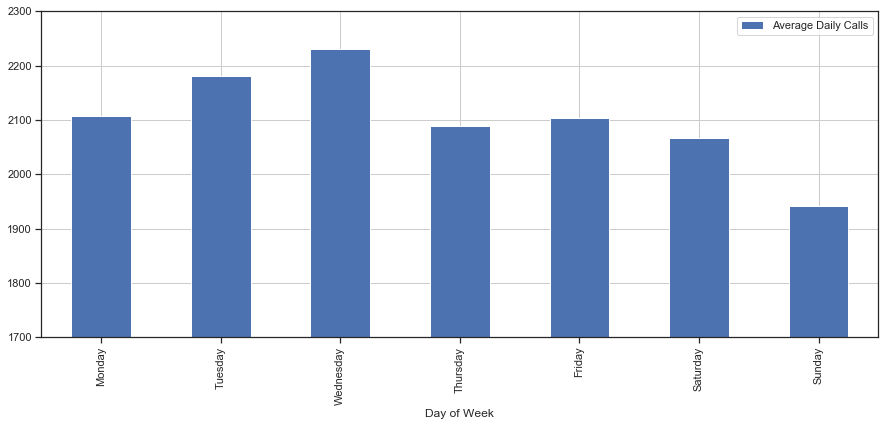

In [204]:
# Plotting
dfj_avg_daily.plot(kind='bar', figsize=(15,6), ylim=(1700, 2300), grid=True)

# Data Preparation

### Data Wrangling: getting the right format

The goal of the ML modeling is to predict the number of future incidents, more precisely those that happen in the following week by category. So, this is a forecasting problem. First, we need to supply the model with the right format. We need to aggregate the data into weekly interval grouped by category. 

In [606]:
# Grouping by category and resampling by week
df_incidents['Incidents'] = 1
df_weekly = df_incidents[['Date', 'Category', 'Incidents']].set_index('Date').groupby([pd.Grouper(freq='1W'), 'Category']).count()

# Create week data integer
df_weekly = df_weekly.reset_index(drop=False)
df_weekly['Week'] = (df_weekly['Date'] - min(df_weekly.Date)).dt.days / 7
df_weekly['Week'] = df_weekly['Week'].astype('int')

There are ways to construct the model. One can create multiple models, each predicting weekly incident volume for each category. This approach is doable, but can be complicated as we need to manage multiple models. An easier approach is to create a single model for all categories. The category is mapped into a numerical representation, namely ordinal encoding. One-hot encoding is another option, but in this case we're going to use tree-based algorithms which handle ordinal encoding just fine.

In [607]:
# Create mapping variables
cat_to_int = {l: i for i, l in enumerate(df_weekly.Category.unique())}
int_to_cat = {v: k for k, v in cat_to_int.items()}


# Apply the mapping to a new column
df_weekly['Category_int']  = df_weekly.Category.map(cat_to_int)
df_weekly = df_weekly.set_index('Date')
df_weekly = df_weekly[['Category_int', 'Week', 'Incidents']].sort_values(by=['Category_int', 'Week'])
df_weekly

,Category_int,Week,Incidents
Date,,,
2003-01-05,0,0,3
2003-01-12,0,1,5
2003-01-19,0,2,5
2003-01-26,0,3,4
2003-02-02,0,4,7
...,...,...,...
2015-02-08,38,631,1
2016-05-01,38,695,1
2016-09-11,38,714,1


Text(0, 0.5, 'Weekly Incidents')

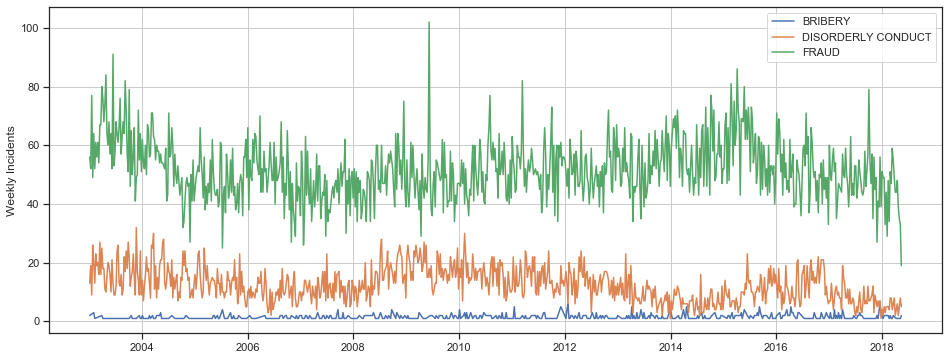

In [306]:
# Plotting
category_to_plot = [3, 5, 12]

plt.figure(figsize=(16, 6))
for c in category_to_plot:
    filt = df_weekly.Category_int == c
    plt.plot(df_weekly.index[filt], df_weekly.Incidents[filt], label=int_to_cat[c])
plt.grid()
plt.legend()
plt.ylabel('Weekly Incidents')

### Feature Engineering

Other than week of the year, encoded category and current weekly incident volume, we can transform current weekly incident volume into other forms:

![title](img/feature_engineering.png)

In [608]:
# Incidents in the week before
df_weekly['Incidents t'] = df_weekly.groupby(['Category_int'])['Incidents'].shift()

# Incidents at t minus incidents at t-1
df_weekly['Incidents_diff_1'] = df_weekly.groupby(['Category_int'])['Incidents t'].diff()

# Log of absolute difference + 1
#df_weekly['Log_diff_1'] = (df_weekly['Incidents_diff_1'].apply(np.abs) + 1).apply(np.log)

# Exp of absolute difference 
df_weekly['Exp_diff_1'] = df_weekly['Incidents_diff_1'].apply(np.abs).apply(np.exp)

# Rolling mean of incidents in the last 2, 3 and 4 weeks
for r in [2, 3, 4, 5, 8, 12, 18, 24]:
    df_weekly[f'Incidents_rolling_{r}'] = df_weekly.groupby(['Category_int'])['Incidents t'].rolling(r, min_periods=1).mean().reset_index(level=0, drop=True)

# Percent of Change
pct_change_eq = lambda x: x.pct_change()
df_weekly['Percent_of_change'] = df_weekly.groupby(['Category_int'])['Incidents t'].apply(pct_change_eq)

# Sign
df_weekly['Sign'] = df_weekly['Incidents_diff_1'].apply(np.sign)

# Z-scores
zscore_eq = lambda x: (x - x.rolling(window=200, min_periods=20).mean()) / x.rolling(window=200, min_periods=20).std()
df_weekly['Z-scores'] = df_weekly.groupby(['Category_int'])['Incidents t'].apply(zscore_eq)

# Percentile
percentile_eq = lambda x: x.rolling(200, min_periods=20).apply(lambda x: pd.Series(x).rank(pct=True)[0])
df_weekly['Percentile'] = df_weekly.groupby(['Category_int'])['Incidents t'].apply(percentile_eq)

# Drop NULL values
df_weekly = df_weekly.dropna()

There seems to be an underreporting issue after May 2018. I decided to remove it from our dataset.

In [609]:
df_weekly = df_weekly[df_weekly.index < pd.to_datetime('1 May 2018')]

In [610]:
df_weekly

,Category_int,Week,Incidents,Incidents t,Incidents_diff_1,Exp_diff_1,Incidents_rolling_2,Incidents_rolling_3,Incidents_rolling_4,Incidents_rolling_5,Incidents_rolling_8,Incidents_rolling_12,Incidents_rolling_18,Incidents_rolling_24,Percent_of_change,Sign,Z-scores,Percentile
Date,,,,,,,,,,,,,,,,,,
2006-11-05,0,200,3,2.0,-4.0,54.598150,4.0,5.333333,6.25,5.8,6.250,5.750000,5.611111,5.500000,-0.666667,-1.0,-1.243709,0.2250
2006-11-12,0,201,4,3.0,1.0,2.718282,2.5,3.666667,4.75,5.6,6.125,5.500000,5.722222,5.291667,0.500000,1.0,-0.841214,0.5300
2006-11-19,0,202,1,4.0,1.0,2.718282,3.5,3.000000,3.75,4.6,4.750,5.250000,5.444444,5.291667,0.333333,1.0,-0.436498,0.5325
2006-11-26,0,203,3,1.0,-3.0,20.085537,2.5,2.666667,2.50,3.2,4.625,5.166667,5.277778,5.041667,-0.750000,-1.0,-1.624430,0.3850
2006-12-03,0,204,4,3.0,2.0,7.389056,2.0,2.666667,2.75,2.6,4.500,5.083333,5.000000,5.041667,2.000000,1.0,-0.822174,0.7800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-03,37,778,12,17.0,6.0,403.428793,14.0,14.000000,13.75,14.4,12.625,12.583333,13.833333,14.291667,0.545455,1.0,0.423940,0.5225
2017-12-10,37,779,10,12.0,-5.0,148.413159,14.5,13.333333,13.50,13.4,12.750,11.750000,13.611111,14.166667,-0.294118,-1.0,-0.577157,0.9375
2017-12-17,37,780,14,10.0,-2.0,7.389056,11.0,13.000000,12.50,12.8,13.125,11.750000,13.333333,13.875000,-0.166667,-1.0,-0.969851,0.5300


In case you are wondering where the integer N in the rolling mean features comes from, this partial autocorrelation plot shows it.

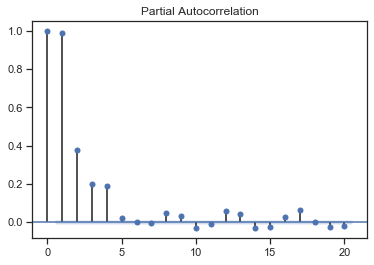

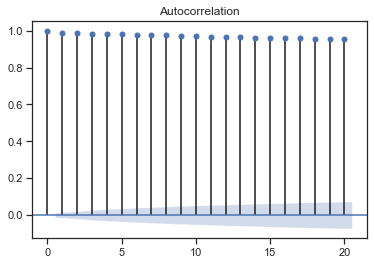

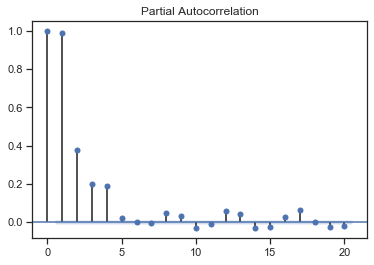

In [359]:
plot_acf(df_weekly['Incidents'], lags=20)
plot_pacf(df_weekly['Incidents'], lags=20)

# Machine Learning Model

### Setting a Baseline Model

How do we know if deploying our model is worth it? One way to see it is by comparing our model with some baseline. In this case, the baseline model gives next week's incident volume prediction the same as current week's volume. It's a lazy approach.

In [361]:
# List all weeks after Jan 1st 2018
val_dates = list(df_weekly.index[df_weekly.index >= pd.to_datetime('1 Jan 2018')].unique())

metrics_baseline = {
    'RMSE': {},
    'MAE': {}
}

# Look through 2018 data one step at a time
for d in val_dates:
    df_dev = df_weekly[df_weekly.index == d]
    
    metrics_baseline['MAE'][d] = mean_absolute_error(df_dev['Incidents'], df_dev['Incidents t'])
    metrics_baseline['RMSE'][d] = mean_squared_error(df_dev['Incidents'], df_dev['Incidents t']) ** 0.5
    
print(f'Average MAE: {np.mean(list(metrics_baseline["MAE"].values()))}')
print(f'Average RMSE: {np.mean(list(metrics_baseline["RMSE"].values()))}')

Average MAE: 10.073002900472558
Average RMSE: 18.67938917221202


So, these are the baseline metrics. Out goal now is to build a model that can beat these stats.

### ML Model: XGBoost

It's one of the commonly used algorithms in Kaggle competition (other than LightGBM). Let's try that.

In [611]:
metrics_xgb = {
    'Training RMSE': {},
    'Training MAE': {},
    'Dev RMSE': {},
    'Dev MAE': {}
}
y_pred_list = []

# Look through 2018 data one step at a time
for d in val_dates:
    # Split into training and dev set
    df_train = df_weekly[df_weekly.index < d]
    df_dev = df_weekly[df_weekly.index == d]
    print(f'Predicting Incidents in Week {d.date()}')
    
    # Split into input and target variables
    x_train, y_train = df_train.drop(columns='Incidents'), df_train.reset_index(drop=False).set_index(['Category_int', 'Date'])[['Incidents']]
    x_dev, y_dev = df_dev.drop(columns='Incidents'), df_dev.reset_index(drop=False).set_index(['Category_int', 'Date'])[['Incidents']]
    
          
    # Training
    model = XGBRegressor(
        max_depth=7, 
        n_estimators=100,
        n_jobs=50,
        gamma=0.5,
        nthread=5,
        random_state=0,
        seed=0)
    model.fit(x_train, y_train)
          
    # Prediction
    y_pred_train = model.predict(x_train)
    y_pred_dev = model.predict(x_dev)
    
    y_pred_dev = pd.DataFrame(y_pred_dev, columns=['Predicted Incidents'])
    y_pred_dev.index = x_dev.index
    y_pred_dev = pd.concat([y_pred_dev, x_dev['Category_int']], axis=1)
    y_pred_dev = y_pred_dev.reset_index(drop=False).set_index(['Category_int', 'Date'])
    y_pred_list.append(y_pred_dev)
    
    # Calculate metrics
    metrics_xgb['Training MAE'][d] = mean_absolute_error(y_train, y_pred_train)
    metrics_xgb['Training RMSE'][d] = mean_squared_error(y_train, y_pred_train) ** 0.5
    metrics_xgb['Dev MAE'][d] = mean_absolute_error(y_dev, y_pred_dev)
    metrics_xgb['Dev RMSE'][d] = mean_squared_error(y_dev, y_pred_dev) ** 0.5

    print(f'Training MAE: {metrics_xgb["Training MAE"][d]}')
    print(f'Training RMSE: {metrics_xgb["Training RMSE"][d]}')
    print(f'Dev MAE: {metrics_xgb["Dev MAE"][d]}')
    print(f'Dev RMSE: {metrics_xgb["Dev RMSE"][d]}')
    print('\n')

y_pred_dev_df = pd.concat(y_pred_list, axis=0)
y_dev_df = df_weekly.reset_index(drop=False).set_index(['Category_int', 'Date'])[['Incidents']]
          
print(f'Average Training MAE: {np.mean(list(metrics_xgb["Training MAE"].values()))}')
print(f'Average Training RMSE: {np.mean(list(metrics_xgb["Training RMSE"].values()))}')
print(f'Average Dev MAE: {np.mean(list(metrics_xgb["Dev MAE"].values()))}')
print(f'Average Dev RMSE: {np.mean(list(metrics_xgb["Dev RMSE"].values()))}')

Predicting Incidents in Week 2018-01-07
Training MAE: 4.587610670191838
Training RMSE: 6.863944638816687
Dev MAE: 9.06489711038528
Dev RMSE: 13.797060420930565


Predicting Incidents in Week 2018-01-14
Training MAE: 4.495276362541275
Training RMSE: 6.6570315628657095
Dev MAE: 9.452959475978728
Dev RMSE: 15.221667149932353


Predicting Incidents in Week 2018-01-21
Training MAE: 4.5014025097907435
Training RMSE: 6.668597143432149
Dev MAE: 8.562616513055914
Dev RMSE: 14.099201298123695


Predicting Incidents in Week 2018-01-28
Training MAE: 4.514697619558556
Training RMSE: 6.719277698198103
Dev MAE: 7.725457323715091
Dev RMSE: 15.1887470211692


Predicting Incidents in Week 2018-02-04
Training MAE: 4.577741501626449
Training RMSE: 6.8722819136314035
Dev MAE: 13.751429344045706
Dev RMSE: 27.693821227788096


Predicting Incidents in Week 2018-02-11
Training MAE: 4.527192198761347
Training RMSE: 6.7488268110416065
Dev MAE: 8.755384802818298
Dev RMSE: 15.579444085430357


Predicting Incidents

MAE is lower than that of the baseline (8.36 vs. 10.07). So is RMSE (15.39 vs. 18.68). We can do a sanity check on the resulting time-series prediction.

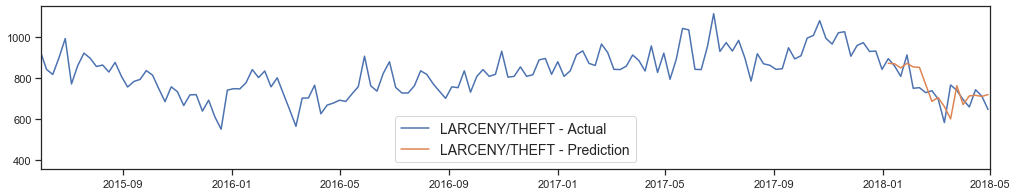

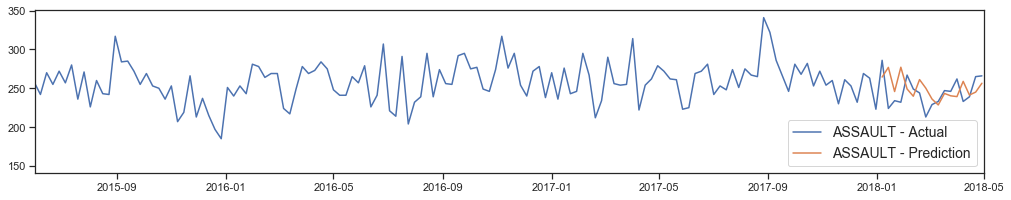

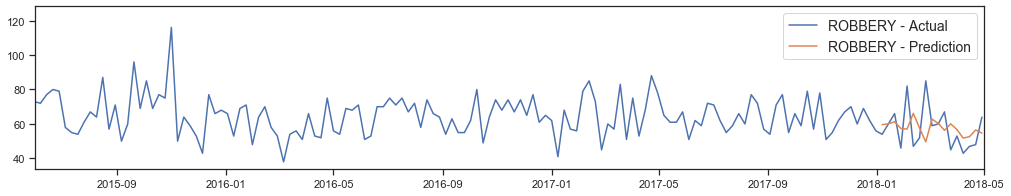

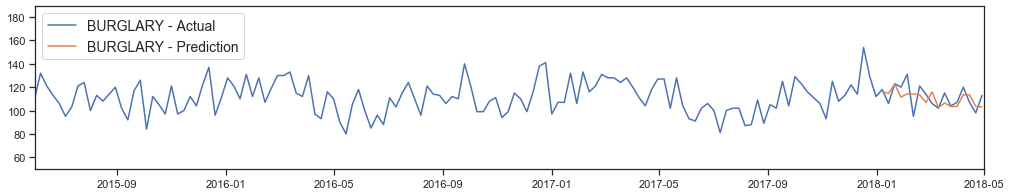

In [507]:
def plot_time_series(y_dev_df, y_pred_dev_df, category, category_mapping, xlim=None):
    if isinstance(category, str):
        plt.figure(figsize=(17, 3))
        plt.plot(y_dev_df.xs(category_mapping[category], level='Category_int'), label=f'{category} - Actual')
        plt.plot(y_pred_dev_df.xs(category_mapping[category], level='Category_int'), label=f'{category} - Prediction')
        plt.legend(fontsize=14)
        if xlim:
            plt.xlim(xlim)
    elif isinstance(category, list):
        for c in category:
            plt.figure(figsize=(17, 3))
            plt.plot(y_dev_df.xs(category_mapping[c], level='Category_int'), label=f'{c} - Actual')
            plt.plot(y_pred_dev_df.xs(category_mapping[c], level='Category_int'), label=f'{c} - Prediction') 
            plt.legend(fontsize=14)
            if xlim:
                plt.xlim(xlim)
    else:
        raise ValueError('"category" has to be either string or list')
        
    

        
cases_to_plot = [
    'LARCENY/THEFT',
    'ASSAULT',
    'ROBBERY',
    'BURGLARY'
]

plot_time_series(y_dev_df, y_pred_dev_df, 
                 category=cases_to_plot, 
                 category_mapping=cat_to_int, 
                 xlim=(pd.to_datetime('1 Jun 2015'), pd.to_datetime('1 May 2018')))

Looks ok, but there are things that could've been better. The model is still struggling when predicting sudden spike. Checking error distribution..

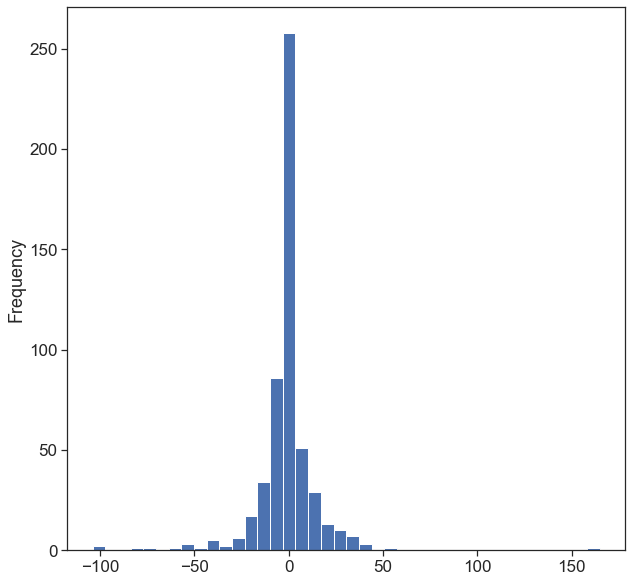

In [545]:
# Plot error distribution
res = pd.concat([y_pred_dev_df, y_dev_df], axis=1).dropna()
res['Error'] = res['Incidents'] - res['Predicted Incidents']
plt.rcParams['axes.labelsize'] = 18
res.Error.plot(kind='hist', bins=40, figsize=(10, 10), fontsize=17)

Seems reasonable. Checking the actual vs. predicted values..

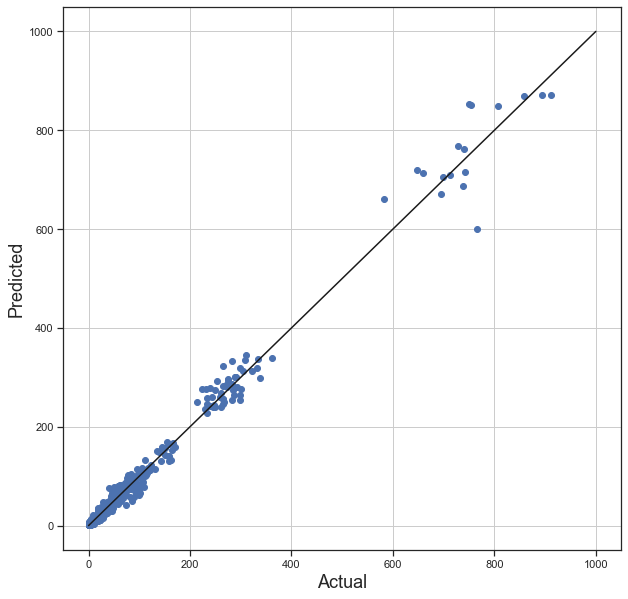

In [536]:
plt.figure(figsize=(10, 10))
plt.scatter(res['Incidents'], res['Predicted Incidents'])
plt.plot([0, 1000], [0, 1000], 'k')
plt.ylabel('Predicted', fontsize=18)
plt.xlabel('Actual', fontsize=18)
plt.grid()

Now looking at which features are more important the the others.

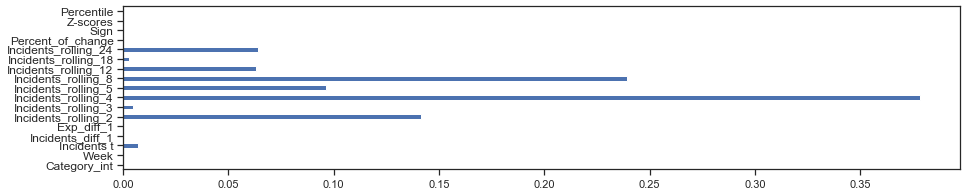

In [613]:
(pd.Series(model.feature_importances_, index=x_dev.columns)
   .plot(kind='barh', figsize=(15, 3))) 